In [1]:
import sys
import os
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [2]:
case = 'whidbey'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)

In [3]:
#in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets')
# Change in_dir to the location of spreadsheet used to run the model 
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets')

no3_f = in_dir/'NO3NO2_load_timeseries.xlsx'
nh4_f = in_dir/'NH4_load_timeseries.xlsx'
flow_f= in_dir/'flow_timeseries.xlsx'

## Create lists of all rivers and WWTPs included in this modeling study

In [4]:
# import excel with information on all rivers and wwtps included in modeling study
# information: type (" River" or " Point Source"), node_id, layer_distribute, basin, country, NH4[kg/year], NO3NO2[kg/year], N-load
source_locations = pandas.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
river_locations = source_locations[source_locations['type']==' River']
wwtp_locations = source_locations[source_locations['type']==' Point Source']
# list of all river and wwtps included in model 
all_rivers_list = river_locations.index.to_list()
all_wwtps_list = wwtp_locations.index.to_list()

In [5]:
print('shape of original file: ', source_locations.shape)
print('shape of river sub-sample: ', river_locations.shape)
print('shape of point source sub-sample: ', wwtp_locations.shape)

shape of original file:  (259, 8)
shape of river sub-sample:  (160, 8)
shape of point source sub-sample:  (99, 8)


### River + Point Source = Total.  i.e. no sources missing `Point Source` designation

In [6]:
[*wwtp_locations]

['type',
 'node_id',
 'layer_distribute',
 'basin',
 'country',
 'NH4[kg/year]',
 'NO3NO2[kg/year]',
 'N-load']

In [7]:
wwtp_locations['N-load'].sum()

26237733.608877182

In [8]:
wwtp_locations['NH4[kg/year]'].sum()+wwtp_locations['NO3NO2[kg/year]'].sum()

26237733.60887719

## Create a list of runs in spreadsheet

In [9]:
run_list = []
no3_xls = pandas.ExcelFile(no3_f)
for sheet in no3_xls.sheet_names:
    run_list.append(sheet)

## Get discharge information

In [10]:
flow_df = pandas.read_excel(flow_f, sheet_name = "Sheet1")
flow_df

,Unnamed: 0,Agate East,Agate West,Anderson east,Anderson west,Artondale,Burley Cr,Butler Cr,Campbell Cr,Chambers Cr,...,Annacis,Iona,Lions Gate,Lulu,NW Langley,Clover Point,Gulf Islands,Macaulay,Saanich,Cushman No 2
0,Sum [m3/sec],1.253321e+02,2.310934e+01,3.084355e+01,9.548360e+01,1.832070e+02,2.308032e+02,7.731925e+01,1.633365e+02,1.538491e+03,...,2.060626e+03,2.337042e+03,3.505959e+02,2.988054e+02,5.428610e+01,1.955901e+02,3.525915,1.955901e+02,3.997614e+01,6.977648e+03
1,Sum [m3/year],1.082870e+07,1.996647e+06,2.664883e+06,8.249783e+06,1.582908e+07,1.994140e+07,6.680383e+06,1.411227e+07,1.329256e+08,...,1.780381e+08,2.019204e+08,3.029149e+07,2.581679e+07,4.690319e+06,1.689898e+07,304639.056000,1.689898e+07,3.453938e+06,6.028688e+08
2,Sum [MGY],2.860942e+03,5.275141e+02,7.040620e+02,2.179593e+03,4.182044e+03,5.268517e+03,1.764957e+03,3.728463e+03,3.511895e+04,...,4.703766e+04,5.334738e+04,8.003011e+03,6.820795e+03,1.239182e+03,4.464712e+03,80.485639,4.464712e+03,9.125306e+02,1.592779e+05
3,MGD,7.838196e+00,1.445244e+00,1.928937e+00,5.971487e+00,1.145766e+01,1.443429e+01,4.835499e+00,1.021497e+01,9.621630e+01,...,1.288703e+02,1.461572e+02,2.192606e+01,1.868711e+01,3.395020e+00,1.223209e+01,0.220509,1.223209e+01,2.500084e+00,4.363779e+02


In [11]:
flow_df['  Agate East']

0    1.253321e+02
1    1.082870e+07
2    2.860942e+03
3    7.838196e+00
Name:   Agate East, dtype: float64

In [12]:
# WWTP: create a dataframe with Annual total flow
wwtp_flow=[]
for wwtp in [*ssm['WWTP_names']]:
    wwtp_flow.append(flow_df[wwtp][2]) 
wwtp_flow_df = pandas.DataFrame({'Annual Total Flow (MG/year)':wwtp_flow}, index=ssm['WWTP_names'])
wwtp_flow_df

,Annual Total Flow (MG/year)
Coupeville,64.422249
Everett Snohomish,4283.165000
La Conner,109.709181
Lake Stevens 002,952.199788
Langley,25.153464
Marysville,1137.967904
Mt Vernon,1489.577185
Mukilteo,426.791208
Oak Harbor Lagoon,662.843746
OF100,4141.558450


In [13]:
# Rivers: create a dataframe with Annual total flow
river_flow=[]
for river in [*ssm['river_names']]:
    river_flow.append(flow_df[river][2]) 
river_flow_df = pandas.DataFrame({'Annual Total Flow (MG/year)':river_flow}, index=ssm['river_names'])
river_flow_df


,Annual Total Flow (MG/year)
Skagit R_1,2.786952e+06
Skagit R_2,2.786952e+06
Snohomish R_1,1.483102e+06
Snohomish R_2,1.483102e+06
Stillaguamish R_1,6.218220e+05
Stillaguamish R_2,6.218220e+05
Whidbey east,2.769104e+04


## Loop through all runs and combine NO3 and NH4 loadings

THIS IS SLOW!!!  

Future upgrade: Put this in a separate notebook and save the output so that I can just read the output in

In [14]:
no3={}
nh4={}
nitrogen = {}
for run in run_list:
    run_tag = run.split('_')[-1]
    print(run_tag)
    no3[run_tag]=pandas.read_excel(no3_f, sheet_name = run, index_col='Unnamed: 0').sum()
    nh4[run_tag]=pandas.read_excel(nh4_f, sheet_name = run, index_col='Unnamed: 0').sum()
    nitrogen[run_tag] = no3[run_tag] + nh4[run_tag]

ref
exist
1b
1c
1d
1e
2a
2b
3b
3c
3e
3f
3g
3h
3i
3l
3m
4c
4d
4e
4f
4g
4h
4i
4j
4k
4l


In [44]:
pandas.options.display.max_columns = None
sum(nitrogen['exist'][all_wwtps_list]==0)

3

In [52]:
len(nitrogen['exist'][all_rivers_list])+len(nitrogen['exist'][all_wwtps_list])

259

In [ ]:
len((nitrogen['exist']))

## Place values in a dataframe

In [15]:
nitrogen_df = pandas.DataFrame(nitrogen)
nitrogen_df

,ref,exist,1b,1c,1d,1e,2a,2b,3b,3c,...,4c,4d,4e,4f,4g,4h,4i,4j,4k,4l
Agate East,2.076955e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,...,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03,4.925721e+03
Agate West,3.832850e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,...,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02,9.365779e+02
Anderson east,5.000554e+02,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,...,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03,3.446357e+03
Anderson west,1.548021e+03,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,...,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04,1.064476e+04
Artondale,2.938509e+03,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,...,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04,1.110986e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Clover Point,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,...,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06,3.247000e+06
Gulf Islands,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,...,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03,2.701324e+03
Macaulay,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,...,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05,6.670328e+05
Saanich,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,...,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04,4.863181e+04


In [35]:
nitrogen_df["exist"].sum()

51748970.952355914

### Use list of WWTP in configuration file to create a boolean array for selecting values

In [16]:
# all_wwtp is a boolean array that shows True for row with WWTP in list
all_wwtp= nitrogen_df.index.isin(all_wwtps_list)
nitrogen_df[all_wwtp].shape

(99, 27)

In [17]:
nitrogen_df[all_wwtp]['exist'].sum()

26214376.93179864

##### The above value is different than the value in the SOG_NB report

### Compare wwtp_locations with nitrogen_df

In [18]:
wwtp_locations.sort_index(ascending=True)['N-load']

  Alderbrook               1.909048e+02
  Alderwood                3.850402e+04
  Anacortes                6.355037e+04
  Annacis                  5.375840e+06
  BP Cherry Point          2.497249e+03
                               ...     
  Vashon                   2.178897e+03
  Warm Beach Campground    1.359896e+02
  West Point               3.344947e+06
  West Rock                4.949032e+03
  Whidbey Naval Station    2.085820e+03
Name: N-load, Length: 99, dtype: float64

In [19]:
nitrogen_df[all_wwtp].sort_index(ascending=True)['exist']

  Alderbrook               1.909048e+02
  Alderwood                3.850402e+04
  Anacortes                6.355037e+04
  Annacis                  5.375840e+06
  BP Cherry Point          2.497249e+03
                               ...     
  Vashon                   2.178897e+03
  Warm Beach Campground    1.359896e+02
  West Point               3.344947e+06
  West Rock                4.949032e+03
  Whidbey Naval Station    2.085820e+03
Name: exist, Length: 99, dtype: float64

### Take difference of two information sources and find where differences occur

In [20]:
np.sum(wwtp_locations.sort_index(ascending=True)['N-load']-nitrogen_df[all_wwtp].sort_index(ascending=True)['exist'])

23356.677078544264

In [21]:
23356.677+26214376.93

26237733.607

### Yup!  This is the missing loading! 

In [22]:
diff=wwtp_locations.sort_index(ascending=True)['N-load']-nitrogen_df[all_wwtp].sort_index(ascending=True)['exist']
bool_diff=(diff>0)
np.sum(bool_diff)

26

<AxesSubplot:>

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


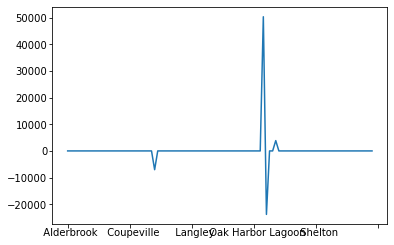

In [24]:
diff.plot()

In [26]:
bool_diff = (np.abs(diff)> 100)
np.sum(bool_diff)

4

### Create list of the 4 WWTPs that have different loadings > 100 

In [27]:
WWTP_diff_list = nitrogen_df[all_wwtp][bool_diff].index.to_list()

/tmp/ipykernel_66770/451149063.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  WWTP_diff_list = nitrogen_df[all_wwtp][bool_diff].index.to_list()


In [28]:
wwtp_locations[wwtp_locations.index.isin(WWTP_diff_list)]

,type,node_id,layer_distribute,basin,country,NH4[kg/year],NO3NO2[kg/year],N-load
Gig Harbor,Point Source,13537,Layer 10,Puget_Main,United States,781.449978,6669.438459,7450.888438
Port Gamble,Point Source,7854,Layer 10,Hood_Canal,United States,14.645508,68.743308,83.388816
Port Townsend,Point Source,4477,Layer 10,Admiralty,United States,376.754522,6073.812074,6450.566596
Port Angeles,Point Source,3224,Layer 10,SJF,United States,35739.383155,27178.400077,62917.783233


In [30]:
nitrogen_df[nitrogen_df.index.isin(WWTP_diff_list)]['exist']

  Gig Harbor       14491.382869
  Port Gamble      23909.629995
  Port Townsend     2578.203392
  Port Angeles     12566.733747
Name: exist, dtype: float64

In [87]:
QAQC_difference={}
# SOG report values
QAQC_difference['sog_report_loading']=wwtp_locations[wwtp_locations.index.isin(WWTP_diff_list)]['N-load'].values
QAQC_difference['sog_report_NO3NO2']=wwtp_locations[wwtp_locations.index.isin(WWTP_diff_list)]['NO3NO2[kg/year]'].values
QAQC_difference['sog_report_NH4']=wwtp_locations[wwtp_locations.index.isin(WWTP_diff_list)]['NH4[kg/year]'].values
# Whidbey report (my) values
QAQC_difference['whidbey_report_loading']=nitrogen_df[nitrogen_df.index.isin(WWTP_diff_list)]['exist'].values
# go back to the no3 and nh4 components in [14]
QAQC_difference['whidbey_report_NO3NO2']= no3["exist"][no3["exist"].index.isin(WWTP_diff_list)].values
QAQC_difference['whidbey_report_NH4']= nh4["exist"][nh4["exist"].index.isin(WWTP_diff_list)].values
QAQC_difference_df = pandas.DataFrame(QAQC_difference, index = WWTP_diff_list)
QAQC_difference_df['difference']=QAQC_difference_df['sog_report_loading']-QAQC_difference_df['whidbey_report_loading'] 
QAQC_difference_df.sum()

sog_report_loading        76902.627082
sog_report_NO3NO2         39990.393919
sog_report_NH4            36912.233163
whidbey_report_loading    53545.950003
whidbey_report_NO3NO2     44877.433367
whidbey_report_NH4         8668.516636
difference                23356.677079
dtype: float64

In [88]:
QAQC_difference_df

,sog_report_loading,sog_report_NO3NO2,sog_report_NH4,whidbey_report_loading,whidbey_report_NO3NO2,whidbey_report_NH4,difference
Gig Harbor,7450.888438,6669.438459,781.449978,14491.382869,14173.821093,317.561776,-7040.494431
Port Gamble,83.388816,68.743308,14.645508,23909.629995,22379.150674,1530.479321,-23826.241180
Port Townsend,6450.566596,6073.812074,376.754522,2578.203392,1452.091546,1126.111846,3872.363204
Port Angeles,62917.783233,27178.400077,35739.383155,12566.733747,6872.370054,5694.363693,50351.049485


In [86]:
wwtp_locations[wwtp_locations.index.isin(WWTP_diff_list)]['N-load'].values

array([ 7450.88843773,    83.38881571,  6450.56659584, 62917.78323254])

### Load the values used in model runs that I wrote out in `create_scenario_pnt_wq_3k.py`

In [96]:
ssm_load=pandas.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting/ssm_exist_load.xlsx', index_col=0)

In [97]:
[*source_locations]

['type',
 'node_id',
 'layer_distribute',
 'basin',
 'country',
 'NH4[kg/year]',
 'NO3NO2[kg/year]',
 'N-load']

In [98]:
#ssm_load.rename(index={np.arange(0,259).tolist():ssm['WWTP_names']})
ssm_load=ssm_load.rename(index={np.arange(0,259)[i]: source_locations.index.to_list()[i] for i in range(len(np.arange(0,259)))})
QAQC_difference_df['ssm_loading']=ssm_load.loc[
    (ssm_load['ssm flow*(nh4+no3no2)'].index.isin(WWTP_diff_list)) & # This will grab WWTPs and Rivers labeled with same name
    (source_locations['type']==' Point Source') # Only choose the WWTP locations
]
QAQC_difference_df

,sog_report_loading,sog_report_NO3NO2,sog_report_NH4,whidbey_report_loading,whidbey_report_NO3NO2,whidbey_report_NH4,difference,ssm_loading
Gig Harbor,7450.888438,6669.438459,781.449978,14491.382869,14173.821093,317.561776,-7040.494431,7450.888438
Port Gamble,83.388816,68.743308,14.645508,23909.629995,22379.150674,1530.479321,-23826.241180,83.388816
Port Townsend,6450.566596,6073.812074,376.754522,2578.203392,1452.091546,1126.111846,3872.363204,6450.566596
Port Angeles,62917.783233,27178.400077,35739.383155,12566.733747,6872.370054,5694.363693,50351.049485,62917.783233


### Save to excel spreadsheet

In [102]:
with pandas.ExcelWriter('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets/QAQC/QAQC_loading.xlsx', mode = 'w') as writer:
        pandas.DataFrame(QAQC_difference_df).to_excel(writer)

In [99]:
# All Rivers and WWTP sources with the names in list
ssm_load.loc[
    (ssm_load['ssm flow*(nh4+no3no2)'].index.isin(WWTP_diff_list))
]

,ssm flow*(nh4+no3no2)
Gig Harbor,14491.382869
Port Gamble,23909.629995
Port Townsend,2578.203392
Port Angeles,12566.733747
Gig Harbor,7450.888438
Port Gamble,83.388816
Port Townsend,6450.566596
Port Angeles,62917.783233


In [100]:
ssm_load[ssm_load.index.isin(WWTP_diff_list)]



,ssm flow*(nh4+no3no2)
Gig Harbor,14491.382869
Port Gamble,23909.629995
Port Townsend,2578.203392
Port Angeles,12566.733747
Gig Harbor,7450.888438
Port Gamble,83.388816
Port Townsend,6450.566596
Port Angeles,62917.783233


In [13]:
def Table1_loadings(case):

    with open(f'../../etc/SSM_config_{case}.yaml','r') as file:
        ssm = yaml.safe_load(file)

    # Add up nitrogen in each scenario across wwtp and rivers in a given scenario
    case_wwtp = nitrogen_df.index.isin(ssm['WWTP_names'])
    case_river = nitrogen_df.index.isin(ssm['river_names'])
    # Add up nitrogen in each scenario across ALL wwtp and rivers in model
    all_wwtp= nitrogen_df.index.isin(all_wwtps_list)
    all_river = nitrogen_df.index.isin(all_rivers_list)
    # Calculate the total nitrogen for rivers and wwtps modified in a particular scenario
    total_scenario_wwtp_nitrogen_df = nitrogen_df[case_wwtp]
    total_scenario_river_nitrogen_df = nitrogen_df[case_river]
    # Calculate the total nitrogen for all rivers and wwtps, for each scenario
    total_wwtp_nitrogen_df = nitrogen_df[all_wwtp]
    total_river_nitrogen_df = nitrogen_df[all_river]
    # Add up loadings in each scenario across: local wwtps, local rivers, all wwtps, all rivers. 
    total_wwtp_loading_local={}
    total_river_loading_local={}
    total_wwtp_loading_all={}
    total_river_loading_all={}
    # run_tag=[]
    # for idx,run in enumerate(run_list):
    #     run_tag.append(run.split('_')[-1])
    #     total_wwtp_loading_local[run_tag[idx]]=total_scenario_wwtp_nitrogen_df.sum()[idx]
    #     total_river_loading_local[run_tag[idx]]=total_scenario_river_nitrogen_df.sum()[idx]
    #     total_wwtp_loading_all[run_tag[idx]]=total_wwtp_nitrogen_df.sum()[idx]
    #     total_river_loading_all[run_tag[idx]]=total_river_nitrogen_df.sum()[idx]
    run_tags={}
    run_tags[case]=[*ssm['run_information']['run_tag'][case]]
    run_tags[case].remove('wqm_reference')
    run_tags[case].remove('wqm_baseline')
    run_tags[case].append('exist')
    run_tags[case]
    wwtp_loads={}
    river_loads={}
    wwtp_loads[case]={}
    river_loads[case]={}
    for idx,run_tag in enumerate(run_tags[case]):
        run=run_tag.split('_')[0]
        print(run_tag, run)
        # total nitrogen loads, by source and scenario
        wwtp_loads[case][run] = nitrogen_df[run][case_wwtp]
        river_loads[case][run] = nitrogen_df[run][case_river]
        # total nitrogen loads across local and all sources, by scenario
        total_wwtp_loading_local[run]=total_scenario_wwtp_nitrogen_df[run].sum()
        total_river_loading_local[run]=total_scenario_river_nitrogen_df[run].sum()
        total_wwtp_loading_all[run]=total_wwtp_nitrogen_df[run].sum()
        total_river_loading_all[run]=total_river_nitrogen_df[run].sum()

    print('Creating WWTP and River loadings dataframe')
    wwtp_load_df = pandas.DataFrame(wwtp_loads[case]).sort_values(by=['exist'], ascending=False)
    river_load_df = pandas.DataFrame(river_loads[case]).sort_values(by=['exist'], ascending=False)

    # Rivers: create a dataframe with Annual total flow
    river_flow=[]
    for river in [*ssm['river_names']]:
        river_flow.append(flow_df[river][2]) 
    river_flow_df = pandas.DataFrame({'Annual Total Flow (MG/year)':river_flow}, index=ssm['river_names'])
    river_load_df=river_load_df.join(river_flow_df) # Adds new column using index to match rows
    
    # WWTP: create a dataframe with Annual total flow
    wwtp_flow=[]
    for wwtp in [*ssm['WWTP_names']]:
        wwtp_flow.append(flow_df[wwtp][2])
    wwtp_flow_df = pandas.DataFrame({'Annual Total Flow (MG/year)':wwtp_flow}, index=ssm['WWTP_names'])
    wwtp_load_df = wwtp_load_df.join(wwtp_flow_df)
    
    # Add the rows with total loading for local wwtps/rivers and all wwtps/rivers
    wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
    river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
    wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
    river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_all, index=['Total Rivers (all in model domain) ']))
    
    # make README 
    this_file = '=HYPERLINK("https://github.com/UWModeling/KingCounty-Rachael/blob/main/notebooks/reports/Table1_NutrientLoadings.ipynb")'
    run_description = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/docs/supporting/KingCounty_Model_Runs.xlsx","KingCounty_Model_Runs.xlsx (USING ORIGINAL RUN TAGS!!!)")'

    created_by = 'Rachael D. Mueller'
    created_at = 'Puget Sound Institute'
    created_from = 'Model results produced by Su Kyong Yun at the Salish Sea Modeling Center'
    units='kg/year'
    created_on = date.today().strftime("%B %d, %Y")
    contact = 'Rachael D Mueller (rdmseas@uw.edu)'
    header = {
        ' ':[created_by, created_at, created_on, this_file, 
            units, contact, created_from, 
            run_description]
    }
    header_df = pandas.DataFrame(header, index=[
        'Created by',
        'Created at',                           
        'Created on',
        'Created with',
        'Units',
        'Contacts',
        'Modeling by',
        'Model Run Overview'])

    # Save to output to 
    excel_output_path = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports')
    print('*************************************************************')
    print('Writing spreadsheet to: ',excel_output_path)
    print('*************************************************************')
    if os.path.exists(excel_output_path)==False:
        print(f'creating: {excel_output_path}')
        os.umask(0) #clears permissions
        os.makedirs(excel_output_path, mode=0o777,exist_ok=True)
    with pandas.ExcelWriter(
        excel_output_path/f'Table1_NutrientLoadings_{case}.xlsx', mode='w') as writer:  
        wwtp_load_df.to_excel(writer, sheet_name=f'WWTP ({case})')
        river_load_df.to_excel(writer, sheet_name=f'Rivers ({case})')
        header_df.to_excel(writer, sheet_name='README')
    print(f'Number of WWTPs in this case: {len(total_scenario_wwtp_nitrogen_df)}')
    print(f'Number of rivers in this case: {len(total_scenario_river_nitrogen_df)}')
    print(f'Number of WWTPs in model: {len(total_wwtp_nitrogen_df)}')
    print(f'Number of rivers in model: {len(total_river_nitrogen_df)}')

In [14]:
Table1_loadings('SOG_NB')
Table1_loadings('whidbey')

1b_all_sog_wwtp_off 1b
1c_all_sog_riv_off 1c
1d_small_sog_wwtp_off 1d
1e_med_sog_wwtp_off 1e
2a_sog_river_0.5times 2a
2b_sog_river_2times 2b
exist exist
Creating WWTP and River loadings dataframe


/tmp/ipykernel_19430/2441274525.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
/tmp/ipykernel_19430/2441274525.py:74: FutureWarning: The frame.append method is deprecated and will be

*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports
*************************************************************
Number of WWTPs in this case: 15
Number of rivers in this case: 9
Number of WWTPs in model: 99
Number of rivers in model: 160
3b 3b
3c 3c
3e 3e
3f 3f
3g 3g
3h 3h
3i 3i
3l 3l
3m 3m
exist exist
Creating WWTP and River loadings dataframe
*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports
*************************************************************


/tmp/ipykernel_19430/2441274525.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
/tmp/ipykernel_19430/2441274525.py:74: FutureWarning: The frame.append method is deprecated and will be

Number of WWTPs in this case: 17
Number of rivers in this case: 7
Number of WWTPs in model: 99
Number of rivers in model: 160


# dev cells below

In [15]:
run_tags={}

In [16]:
case = 'whidbey'
with open(f'../../etc/SSM_config_{case}.yaml','r') as file:
    ssm = yaml.safe_load(file)

In [17]:
# Add up nitrogen in each scenario across wwtp and rivers in a given scenario
case_wwtp = nitrogen_df.index.isin(ssm['WWTP_names'])
case_river = nitrogen_df.index.isin(ssm['river_names'])
# Add up nitrogen in each scenario across ALL wwtp and rivers in model
all_wwtp= nitrogen_df.index.isin(all_wwtps_list)
all_river = nitrogen_df.index.isin(all_rivers_list)

In [18]:
# Calculate the total nitrogen for rivers and wwtps modified in a particular scenario
total_scenario_wwtp_nitrogen_df = nitrogen_df[case_wwtp]
total_scenario_river_nitrogen_df = nitrogen_df[case_river]
# Calculate the total nitrogen for all rivers and wwtps, for each scenario
total_wwtp_nitrogen_df = nitrogen_df[all_wwtp]
total_river_nitrogen_df = nitrogen_df[all_river]

In [19]:
# Add up loadings in each scenario across: local wwtps, local rivers, all wwtps, all rivers. 
total_wwtp_loading_local={}
total_river_loading_local={}
total_wwtp_loading_all={}
total_river_loading_all={}
run_tag=[]
for idx,run in enumerate(run_list):
    run_tag.append(run.split('_')[-1])
    total_wwtp_loading_local[run_tag[idx]]=total_scenario_wwtp_nitrogen_df.sum()[idx]
    total_river_loading_local[run_tag[idx]]=total_scenario_river_nitrogen_df.sum()[idx]
    total_wwtp_loading_all[run_tag[idx]]=total_wwtp_nitrogen_df.sum()[idx]
    total_river_loading_all[run_tag[idx]]=total_river_nitrogen_df.sum()[idx]
test = pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)'])
test = pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)'])
test = pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) '])
test = pandas.DataFrame(total_river_loading_all, index=['Total Rivers (all in model domain) '])
test

,ref,exist,1b,1c,1d,1e,2a,2b,3b,3c,...,4c,4d,4e,4f,4g,4h,4i,4j,4k,4l
Total Rivers (all in model domain),1.999981e+07,2.551124e+07,2.551124e+07,2.310061e+07,2.551124e+07,2.551124e+07,2.430593e+07,2.792189e+07,2.551124e+07,1.912211e+07,...,2.551124e+07,2.551124e+07,2.551124e+07,2.551124e+07,2.551124e+07,2.551124e+07,2.551124e+07,2.551124e+07,2.534466e+07,2.584439e+07


In [20]:
print(f'Number of WWTPs in this case: {len(total_scenario_wwtp_nitrogen_df)}')
print(f'Number of rivers in this case: {len(total_scenario_river_nitrogen_df)}')
print(f'Number of WWTPs in model: {len(total_wwtp_nitrogen_df)}')
print(f'Number of rivers in model: {len(total_river_nitrogen_df)}')

Number of WWTPs in this case: 17
Number of rivers in this case: 7
Number of WWTPs in model: 99
Number of rivers in model: 160


In [21]:
run_tags[case]=[*ssm['run_information']['run_tag'][case]]
run_tags[case].remove('wqm_reference')
run_tags[case].remove('wqm_baseline')
run_tags[case].append('exist')
run_tags[case]

['3b', '3c', '3e', '3f', '3g', '3h', '3i', '3l', '3m', 'exist']

# Create table of nutrient loading for each set of runs
1. WWTPs
     1. WWTP ordered from largest to smallest load in 2014
     2. Total load of WWTPs altereed in the scenario
     3. Total load of all WWTPs used in the scenario
    
    
2. Rivers
   1. Rivers ordered from largest to smallest load in 2014
    2. Total load of Rivers altereed in the scenario
    3. Total load of all Rivers used in the scenario

#### Loop through all runs and get loadings

In [22]:
wwtp_loads={}
river_loads={}
wwtp_loads[case]={}
river_loads[case]={}
for run in run_tags[case]:
    wwtp_loads[case][run] = nitrogen_df[run][case_wwtp]
    river_loads[case][run] = nitrogen_df[run][case_river]

In [23]:
wwtp_load_df = pandas.DataFrame(wwtp_loads[case]).sort_values(by=['exist'], ascending=False)
river_load_df = pandas.DataFrame(river_loads[case]).sort_values(by=['exist'], ascending=False)

# Add the rows with total loading for local wwtps/rivers and all wwtps/rivers
wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_all, index=['Total Rivers (all in model domain) ']))

/tmp/ipykernel_19430/489017650.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
/tmp/ipykernel_19430/489017650.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
/tmp/ipykernel_19430/489017650.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
/tmp/ipykernel_19430/489017650.py:8: FutureWarning: The frame.append method is deprecated and will be removed

# Save values to output Excel

In [24]:
# make README 
this_file = '=HYPERLINK("https://github.com/UWModeling/KingCounty-Rachael/blob/main/notebooks/reports/Table1_NutrientLoadings.ipynb")'
run_description = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/docs/supporting/KingCounty_Model_Runs.xlsx","KingCounty_Model_Runs.xlsx") UPDATE?'

created_by = 'Rachael D. Mueller'
created_at = 'Puget Sound Institute'
created_from = 'Model results produced by Su Kyong Yun at the Salish Sea Modeling Center'
units='kg/year'
created_on = date.today().strftime("%B %d, %Y")
contact = 'Rachael D Mueller (rdmseas@uw.edu)'
header = {
    ' ':[created_by, created_at, created_on, this_file, 
        contact, created_from, units,
        run_description]
}
header_df = pandas.DataFrame(header, index=[
    'Created by',
    'Created at',                           
    'Created on',
    'Created with',
    'Units',
    'Contacts',
    'Modeling by',
    'Model Run Overview'])

# Save to output to 
excel_output_path = pathlib.Path(ssm['paths']['processed_output'])/case/'spreadsheets'
print('*************************************************************')
print('Writing spreadsheet to: ',excel_output_path)
print('*************************************************************')
if os.path.exists(excel_output_path)==False:
    print(f'creating: {excel_output_path}')
    os.umask(0) #clears permissions
    os.makedirs(excel_output_path, mode=0o777,exist_ok=True)
with pandas.ExcelWriter(
    excel_output_path/f'Table1_NutrientLoadings.xlsx', mode='w') as writer:  
    wwtp_load_df.to_excel(writer, sheet_name=f'WWTP ({case})')
    river_load_df.to_excel(writer, sheet_name=f'Rivers ({case})')
    header_df.to_excel(writer, sheet_name='README')
print(f'Number of WWTPs in this case: {len(total_scenario_wwtp_nitrogen_df)}')
print(f'Number of rivers in this case: {len(total_scenario_river_nitrogen_df)}')
print(f'Number of WWTPs in model: {len(total_wwtp_nitrogen_df)}')
print(f'Number of rivers in model: {len(total_river_nitrogen_df)}')

*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets
*************************************************************
Number of WWTPs in this case: 17
Number of rivers in this case: 7
Number of WWTPs in model: 99
Number of rivers in model: 160


In [25]:
wwtp_load_df.sum()

3b       2.500232e+07
3c       2.863931e+07
3e       2.852575e+07
3f       2.732282e+07
3g       2.643196e+07
3h       2.754552e+07
3i       2.752576e+07
3l       2.863931e+07
3m       2.863931e+07
exist    2.863931e+07
ref      1.420737e+07
1b       2.693485e+07
1c       2.742684e+07
1d       2.731552e+07
1e       2.704618e+07
2a       2.742684e+07
2b       2.742684e+07
4c       2.443943e+07
4d       2.644732e+07
4e       2.576608e+07
4f       2.410466e+07
4g       2.618494e+07
4h       2.494248e+07
4i       2.706415e+07
4j       2.670148e+07
4k       2.742684e+07
4l       2.742684e+07
dtype: float64

# Create function to do this work

In [26]:
Table1_loadings('whidbey')

3b 3b
3c 3c
3e 3e
3f 3f
3g 3g
3h 3h
3i 3i
3l 3l
3m 3m
exist exist
Creating WWTP and River loadings dataframe
*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports
*************************************************************
Number of WWTPs in this case: 17
Number of rivers in this case: 7
Number of WWTPs in model: 99
Number of rivers in model: 160


/tmp/ipykernel_19430/2441274525.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
/tmp/ipykernel_19430/2441274525.py:74: FutureWarning: The frame.append method is deprecated and will be

In [27]:
Table1_loadings('SOG_NB')

1b_all_sog_wwtp_off 1b
1c_all_sog_riv_off 1c
1d_small_sog_wwtp_off 1d
1e_med_sog_wwtp_off 1e
2a_sog_river_0.5times 2a
2b_sog_river_2times 2b
exist exist
Creating WWTP and River loadings dataframe
*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports
*************************************************************
Number of WWTPs in this case: 15
Number of rivers in this case: 9
Number of WWTPs in model: 99
Number of rivers in model: 160


/tmp/ipykernel_19430/2441274525.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_local, index=['Total WWTPs (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  river_load_df=river_load_df.append(pandas.DataFrame(total_river_loading_local, index=['Total Rivers (altered in this report)']))
/tmp/ipykernel_19430/2441274525.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wwtp_load_df=wwtp_load_df.append(pandas.DataFrame(total_wwtp_loading_all, index=['Total WWTPs (all in model domain) ']))
/tmp/ipykernel_19430/2441274525.py:74: FutureWarning: The frame.append method is deprecated and will be